# Notes:

* this Notebook is now modified to match to a smaller maze results
* maze radius is set to be bigger then the far targets in order to reduce collisions
* results are written to MultipleTargets tb log dir in order to keep all logs at the same place

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files, get_multi_targets_circle_envs
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

from IPython.display import Image
import ipyplot
import glob

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:

targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')
REWARDS = Rewards(target_arrival=1, collision=-1, timeout=0, fall=-1, idle=-0.2e-3)


_, eval_env = get_multi_targets_circle_envs(radius=3.7,
                                            targets=targets,
                                            timeout_steps=200,
                                            rewards=REWARDS,
                                            monitor_dir="logs/FineTuneMultiple/tmp",
                                            xy_in_obs=False)
                              

# Visual Results
load trained model and show visual results on subset of the targets:

In [16]:
trained_model_dir = os.path.join("logs", "MultiTargets","TargetEpsilon0.5")

new_results_dir = os.path.join("logs", "FineTuneMultiple")

model = DDPG.load(os.path.join(trained_model_dir, "best_model"))

All videos and gifs already saved.
Uncomment this cell to recreate evaluation videos again.

In [18]:
N_TARGETS_TO_VISUALIZE = 3

rewards = []
reach_target_count = 0

for tgt in range(N_TARGETS_TO_VISUALIZE):
    episode_reward = 0
    done = False
    
    video_path = os.path.join(new_results_dir, "OldFinal", "final" + str(tgt) + ".avi")
    # print(video_path)
    
    obs = eval_env.reset(create_video=True, video_path=video_path, target_index=tgt)
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = eval_env.step(action)
        episode_reward += reward
        
    rewards.append("reward: " + str(episode_reward))
    if episode_reward > 0:
        reach_target_count += 1
    
_ = eval_env.reset()

Evaluation.create_gifs_from_avi(os.path.join(new_results_dir, "OldFinal"))

print("reached target:", reach_target_count)

reached target: 3


In [21]:
gifs = glob.glob(os.path.join(new_results_dir, "OldFinal","*.gif"))
gifs.sort()
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
labels.sort()
# ipyplot.plot_images(gifs, labels, rewards, img_width=200)
ipyplot.plot_images(gifs, labels, img_width=200)

# Per Target Success Rate (During Training)

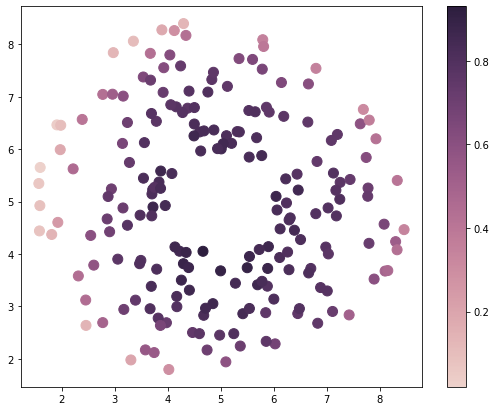

In [87]:
# print(targets)
target_success_rates = np.genfromtxt(os.path.join(trained_model_dir, "per_target_success_rate.csv"))

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=[9,7])
points = ax.scatter(x=targets[:,0], y=targets[:,1], c=target_success_rates, s=100, cmap=cmap)
f.colorbar(points)

# Keep training

In [ ]:
RUN_NAME="TargetEpsilon0.5"
os.makedirs(os.path.join("logs/MultiTargets", RUN_NAME), exist_ok=True)

TOTAL_TIME_STEPS = 2_000_000
LEARNING_RATE = 0.2e-7
REDUCE_LR = True
EXPLORATION_NOISE_STD = 0.005

EVAL_FREQ = 40000
VIDEO_FREQ = 5

# should be similar to pretrained model:
REWARDS = Rewards(target_arrival=10, collision=-20, timeout=-10, idle=-0.01)
TIMEOUT_STEPS = 1000 

In [ ]:
maze_env, eval_maze_env = get_multi_targets_circle_envs(radius=2.7,
                                                        targets = targets,
                                                        timeout_steps=TIMEOUT_STEPS,
                                                        rewards=REWARDS,
                                                        monitor_dir="logs/FineTuneMultiple/results")
 

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir="logs/FineTuneMultiple",
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

def lr_func(progress):
    if progress < 0.5 and REDUCE_LR:
        return LEARNING_RATE/5
    return LEARNING_RATE

exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

model = DDPG.load(os.path.join(trained_model_dir, "best_model"), 
                  env=maze_env,
                  custom_objects=dict(tensorboard_log="./logs/MultiTargets/tb",
                                     learning_rate=lr_func,)
                 )

In [ ]:
# clear old videos: 
clear_files('logs/FineTuneMultiple/*.gif')
clear_files('logs/FineTuneMultiple/*.avi')

In [ ]:
start = time.time()

model.learn(total_timesteps=TOTAL_TIME_STEPS, 
            callback=callback,
            tb_log_name="FT_")

print("time", time.time() - start)

In [ ]:
Evaluation.plot_train_eval_results("logs/FineTuneMultiple", 30)

In [ ]:
# create gifs and plot them:
Evaluation.create_gifs_from_avi("logs/FineTuneMultiple/")

gifs = glob.glob("logs/FineTuneMultiple/*_steps.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=200)